In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

#matplotlib
import matplotlib.pyplot as plt


In [3]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 9912422/9912422 [00:00<00:00, 108001483.92it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 89996800.76it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27929679.57it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17381869.31it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True) #This means that in each epoch, the order of the training examples will be different

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)
len(train_dataloader)

1875

In [5]:
# Setup device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
class CNNDigitRecognizer(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 7 *7,
                  out_features=output_shape)
    )
  def forward(self, x:torch.Tensor):
    features = self.feature_extractor(x)
    return self.classifer(features)

In [11]:
model_1 = CNNDigitRecognizer(input_shape=1,
                             hidden_units=16,
                             output_shape=len(train_data.classes)).to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=.1)

In [21]:
import requests
from pathlib import Path

# Download helper functions from github
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/NikNemani/DigitRecognizer/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [24]:
from helper_functions import *
from tqdm.auto import tqdm #provides a nice looking progress bar for iterables (optional)
torch.manual_seed(50)

epochs = 5
start_time = d_timer() # Record start time
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  train_batches(model=model_1,
                data_loader=train_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                accuracy_fn=accuracy_fn,
                device=device)

  test_batches(model=model_1,
                data_loader=train_dataloader,
                loss_fn=loss_fn,
                accuracy_fn=accuracy_fn,
               device=device)
end_time = d_timer() # Record end time
train_time(start=start_time,
           end=end_time)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.27150 | Train accuracy: 90.79%
Test loss: 0.06392 | Test accuracy: 98.19%

Epoch: 1
---------
Train loss: 0.05925 | Train accuracy: 98.22%
Test loss: 0.04607 | Test accuracy: 98.55%

Epoch: 2
---------
Train loss: 0.04538 | Train accuracy: 98.57%
Test loss: 0.03107 | Test accuracy: 99.07%

Epoch: 3
---------
Train loss: 0.03685 | Train accuracy: 98.80%
Test loss: 0.02945 | Test accuracy: 99.06%

Epoch: 4
---------
Train loss: 0.03232 | Train accuracy: 98.97%
Test loss: 0.02440 | Test accuracy: 99.25%

Train time: 101.866 seconds


101.86619683999993

As expected, the CNN model took a bit longer, almost 20 seconds longer. This is to be expected as the CNN model is more complex and has more layers than the base Digit Recognizer model. The CNN model also performs a bit better, hitting 99.25% accuracy on the Test set compared to 95.08% accuracy in 5 epochs. To further illustrate this, I made a simple dataframe using pandas

In [7]:
import pandas as pd
data = {
    'Model': ['Base Digit Recognizer', 'CNN Model'],
    'Training Time (s)': [83.185, 101.866],
    'Test Accuracy (%)': [95.08, 99.25]
}
compare_results = pd.DataFrame(data)
compare_results = compare_results.reset_index(drop=True)
compare_results

,Model,Training Time (s),Test Accuracy (%)
0,Base Digit Recognizer,83.185,95.08
1,CNN Model,101.866,99.25


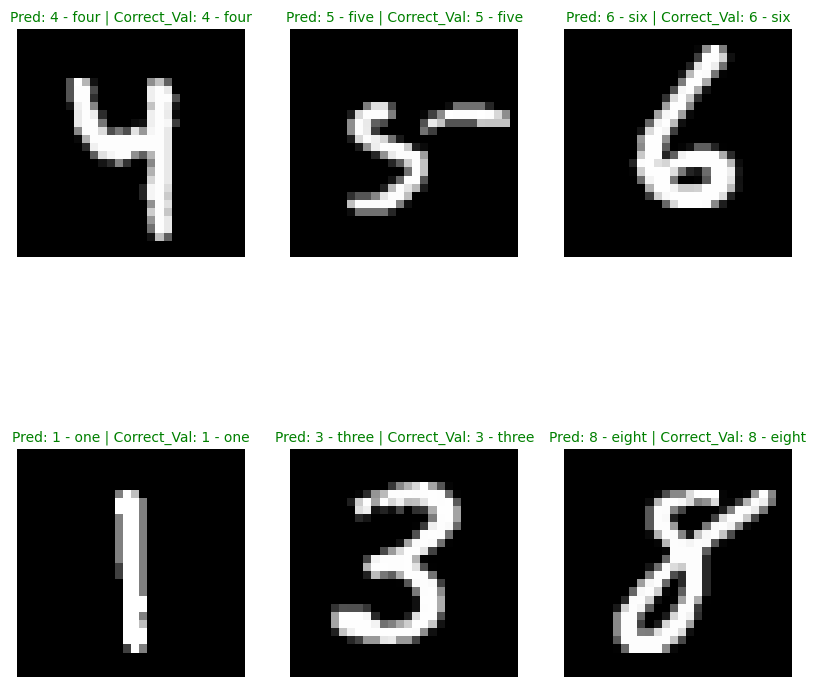

In [28]:
import random
class_names = train_data.classes
test_samps = []
test_labs = []
for sample, label in random.sample(list(test_data), k=6):
  test_samps.append(sample)
  test_labs.append(label)

#use make predictions helper function to make predictions on samples
pred_probs = make_preds(model_1,test_samps,device=device)
# going for pred probabilities to prediction labels
pred_labels = pred_probs.argmax(dim=1)

# Plot predictions using plt
plt.figure(figsize=(10,10))
n_rows = 2
n_cols = 3

for i, sample in enumerate(test_samps):
  plt.subplot(n_rows,n_cols,i+1)
  plt.imshow(sample.squeeze(),cmap='gray')
  # what my model predicted
  pred_label = class_names[pred_labels[i]]
  # what the correct classification is
  actual_label = class_names[test_labs[i]]
  title_text = f"Pred: {pred_label} | Correct_Val: {actual_label}"
  # Check for equality and change title colour accordingly
  if pred_label == actual_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False)